# Alexandra Gavrilina

# HOMEWORK 2: COALESCENT WITH MUTATION

In [1]:
import numpy as np
import random
import math
import scipy
from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Basics

Chromosome is an interval $[0, 1]$.

Individual (or individual’s genome) is a set of $M$ chromosomes, numbered from $0$ to $M − 1$.

Chromosomes with the same id (from different individuals) are related by a single tree genealogy (no recombination).

Genealogies for chromosomes with different ids are simulated independently from each other.

## 2. Coalescence with mutation
Let there be $K$ lineages. Mutation rate is $\mu$, effective population size over time is $ν(t)$. Assume that $ν(t)$ is piecewise constant function.

Coalescence with mutation is a Poisson process with the (variable) rate

$$\omega(K, t) = K \mu + \dfrac{1}{v(t)} \begin{pmatrix} K \\ 2 \end{pmatrix}.$$

Simulation scheme.

(1) Set $t = 0$, initialise $K$.

(2) Sample time $T$ till the next event from Poisson process with the rate $\omega (K, t)$. Set $t = t + T$.

(3) Generate type of the event following Bernoulli distribution with weights proportional to Kµ (mutation) and $\dfrac{1}{v(t)} \begin{pmatrix} K \\ 2 \end{pmatrix}$ (coalescence).

* Mutation: sample ancestral lineages $l$ where mutation occurs independently from $K$ available lineages. Sample mutation position $p$ on a genome uniformly on $[0, 1]$. All individuals which are decedents of $l$ get variant $1$ at position $p$. All other individuals have variant $0$ at position $p$.

* Coalescence. Choose uniformly a random pair of lineages $l_1$ and $l_2$. These two lineages coalesce at time $t$. Update genealogy. Set $K = K − 1$.

(4) stop if $K = 1$. Otherwise go to step 2.

In [2]:
'''
M: number of chromosomes
K: lineages
mu: mutation rate
'''
M = 100
K = 3
mu = 10000

In [3]:
'''
T: time periods
N: population sizes
'''
T = np.array([0, .015, .05, .1], dtype=float)
N = np.array([1, 5, 7, 10], dtype=int)

In [4]:
'''
Population size at time t
Input: time t
Output: piecewise fuction v(t)
'''
def v(t):
    return np.piecewise(t, (t < 10, 10 >= t >= 20, t >= 20), (1, 2, 3))

In [5]:
'''
Poisson process rate
Input: K, mu, v(t)
Output: w(K, mu)
'''
def rate(K, t):
    return K*mu + (1/v(t))*scipy.special.binom(K, 2)

In [6]:
'''
Add chromosome function (addition of a chromosome to an individual and its descendants)
Input: l (lineage), p (position), mutated (1 or 0)
'''
def add_chromosome(l, p, mutated):
    l[0][1][p] = mutated # zero element of the list is a nested list; the first element is a dictionary
    for i in range(1, len(l)): # if the lineage list contains a descendant or two, repeat
        add_chromosome(l[i], p, mutated)

In [7]:
'''
Coalescence and mutation
Input: K, mu, T, N
Output: tree
'''
def coal_mut(K, mu, T, N):
    '''
    i: individual, {}: chromosomes, 0.0: coalescence time, 0: number of mutations
    '''
    tree = list([[i, {}, 0.0, 0]] for i in range(K)) # tree base

    t = 0
    
    while K != 1:
        W = rate(K, t) # Poisson process rate
        t += np.random.exponential(1 / W) # from Poisson process
        
        if (mu != 0) and np.random.binomial(1, K*mu / W): # binomial distribution
            l = np.random.randint(0, K) # randomly select one descendant who is susceptible to mutation
            p = np.random.random() # randomly select a chromosome that is susceptible to mutation
            tree[l][0][3] += 1 # mutation counter
            # we pass this mutation to all descendants of the individual
            add_chromosome(tree[l], p , 1)
            # the remaining branches get zero
            for i in range(l):
                add_chromosome(tree[i], p, 0)
            for i in range(l + 1, K):
                add_chromosome(tree[i], p, 0)
        else:
            l1, l2 = np.random.choice(K, 2, replace=False) # pair of lineages
            K -= 1 # decrease K: K = K - 1
            ancestors = list([[i, {}, t, 0]] for i in range(K))
            for i in range(min(l1, l2)):
                ancestors[i].append(tree[i])
            tree[min(l1, l2) + 1], tree[max(l1, l2)] = tree[max(l1, l2)], tree[min(l1, l2) + 1]
            ancestors[min(l1, l2)].append(tree[min(l1, l2)])
            ancestors[min(l1, l2)].append(tree[min(l1, l2) + 1])
            for i in range(min(l1, l2) + 1, K):
                ancestors[i].append(tree[i + 1])
            tree = ancestors
            
    return tree

In [8]:
tree = coal_mut(K, mu, T, N)

### Standard deviation

In [9]:
coal_1 = []
for i in range(10000):
    a1 = tree[0][1][0][2]
    a2 = tree[0][0][2] 
    coal_1.append(a1)
    coal_1.append(a2)

#### Times of coalescent

In [10]:
coal_12 = np.asarray(coal_1)
coal_12

array([0.36252014, 1.81087524, 0.36252014, ..., 1.81087524, 0.36252014,
       1.81087524])

#### Standard deviation

In [11]:
np.std(coal_12)

0.7241775523103738

### Distribution of mutations

#### Edge length

In [12]:
len1 = abs(tree[0][1][1][0][2] - tree[0][1][0][2])
len2 = abs(tree[0][0][2] - tree[0][1][0][2])

In [13]:
len1, len2

(0.36252013548738965, 1.448355104620748)

#### Number of mutations

In [14]:
mut1 = tree[0][1][1][0][3] # on edge 1
mut2 = tree[0][1][0][3] # on edge 2

In [15]:
mut1, mut2

(3682, 14265)

$l_1  / N_{mut1}$

In [16]:
len1 / mut1

9.845739692759089e-05

$l_2 / N_{mut2}$

In [17]:
len2 / mut2

0.00010153207883776711

$ l_1  / N_{mut1} - l_2 / N_{mut2}$

In [18]:
abs(len1 / mut1 - len2 / mut2)

3.0746819101762254e-06

### Plot

In [19]:
tr = []
for i in range(100):
    tr.append(coal_mut(K, mu, T, N))

#### Edge length

In [20]:
leng1 = []
leng2 = []
for i in range(100):
    leng1.append(abs(tr[i][0][1][1][0][2] - tr[i][0][1][0][2]))
    leng2.append(abs(tr[i][0][0][2] - tr[i][0][1][0][2]))

#### Number of mutations

In [21]:
muta1 = []
muta2 = []
for i in range(100):
    muta1.append(tr[i][0][1][1][0][3])
    muta2.append(tr[i][0][1][0][3])

In [22]:
leng11 = np.asarray(leng1)
leng22 = np.asarray(leng2)
muta11 = np.asarray(muta1)
muta22 = np.asarray(muta2)

In [23]:
mutat = np.hstack((muta11, muta22))
lengt = np.hstack((leng11, leng22))

Text(0, 0.5, 'Edge length')

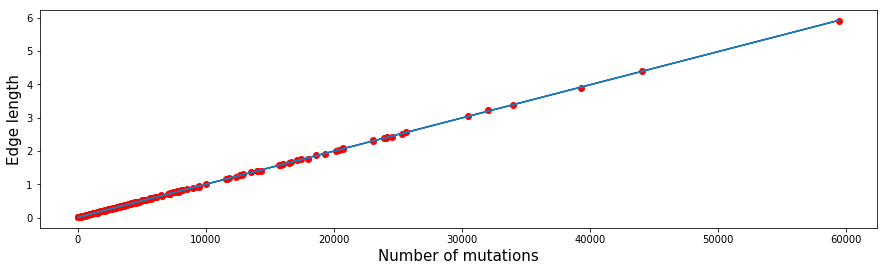

In [24]:
plt.figure(figsize=(15,4))
plt.scatter(mutat, lengt, c='r') # (number of mut, edge length)
x = np.polyfit(mutat, lengt, 1) # least squares polynomial fit
y = np.polyval(x, mutat) # evaluate a polynomial at specific values
plt.plot(mutat, y) # plot 
plt.xlabel('Number of mutations', fontsize=15)
plt.ylabel('Edge length', fontsize=15)